## Description

### Model

A single LSTM layer was used for this notebook. Here, the model performed best with a dropout of 0.4 and a learning rate of 1e-4. To handle varied sentence lengths pack_padded_sequence was used from the PyTorch library. Early stopping was employed during training.

### Results

The highest accuracy achieved is roughly 63%. Based on the training and validation plots, the model is overfitting on the dataset, which could be due to insufficient data.

### Resources Used:

*   [Multiclass Text Classification using LSTM in Pytorch](https://towardsdatascience.com/multiclass-text-classification-using-lstm-in-pytorch-eac56baed8df)
*   [Build Your First Text Classification model using PyTorch](https://www.analyticsvidhya.com/blog/2020/01/first-text-classification-in-pytorch/)
* [TORCH.NN.UTILS.RNN.PACK_PADDED_SEQUENCE](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html)



## Imports

In [1]:
# !pip install torchtext==0.6.0

In [2]:
import math
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

import torch
import torch.nn as nn
import torchtext
from torchtext.data import Field, TabularDataset
from torchtext.vocab import Vectors
import torch.nn.functional as F
from torch import nn, optim
from torch.nn.utils.rnn import pack_padded_sequence

warnings.filterwarnings("ignore", category=UserWarning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Definitions

In [3]:
batch_size = 16

PATH = "/content/drive/MyDrive/Class Stuff/Fall23/NLP/Final Project/Data"
train_path = os.path.join(PATH,"train.csv")
val_path = os.path.join(PATH,"val.csv")
test_path = os.path.join(PATH,"test.csv")

## Data Loaders

In [4]:
TEXT = Field(sequential=True, lower=True, include_lengths=False, batch_first=True)
LABEL = Field(sequential=False, use_vocab=False)

fields = [('sentence', TEXT), ('label', LABEL)]

In [5]:
train_data = TabularDataset(
    path=train_path,
    format="csv",
    fields=fields,
    skip_header=True
)

val_data = TabularDataset(
    path=val_path,
    format="csv",
    fields=fields,
    skip_header=True
)

test_data = TabularDataset(
    path=test_path,
    format="csv",
    fields=fields,
    skip_header=True
)

In [6]:
glove_vectors = torchtext.vocab.GloVe(name="6B", dim=50, max_vectors=50_000)

In [7]:
TEXT.build_vocab(train_data, vectors=glove_vectors, max_size=50000)
LABEL.build_vocab(train_data)

TEXT.build_vocab(val_data, vectors=glove_vectors, max_size=50000)
LABEL.build_vocab(val_data)

TEXT.build_vocab(test_data, vectors=glove_vectors, max_size=50000)
LABEL.build_vocab(test_data)

In [8]:
train_iter = torchtext.data.BucketIterator(
    dataset=train_data,
    batch_size=batch_size
)

val_iter = torchtext.data.BucketIterator(
    dataset=val_data,
    batch_size=batch_size
)

test_iter = torchtext.data.BucketIterator(
    dataset=test_data,
    batch_size=batch_size
)

In [9]:
N_train = 0
N_val = 0
N_test = 0
for x,y in train_iter:
  N_train+=len(x[0])
for x,y in val_iter:
    N_val+=len(x[0])
for x,y in test_iter:
    N_test+=len(x[0])

## Model Definition

In [10]:
class LSTM_model(torch.nn.Module):
    def __init__(self, embeddings, hidden_dim,dropout = 0.1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(dropout)
        self.embeddings = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.lstm = nn.LSTM(embeddings.size(1), hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        s = torch.sum(x != 0, dim=1)
        x = self.embeddings(x)
        x = self.dropout(x)
        x_pack = pack_padded_sequence(x, s, batch_first=True, enforce_sorted=False)
        out_pack, (ht, ct) = self.lstm(x_pack)
        out = self.linear(ht[-1])
        return out

In [11]:
model = LSTM_model(TEXT.vocab.vectors,hidden_dim = 100,dropout=0.4)

In [12]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Number of parameters in the transformer model: {params}")

Number of parameters in the transformer model: 247052


## Plot Definitions

In [13]:
def show_performance_curves(training_loss,validation_loss,training_accuracy,validation_accuracy,test_accuracy,last_epoch):

    plt.figure(figsize=(5, 3))
    plt.plot(training_loss[:last_epoch],label='Training',color='g')
    plt.plot(validation_loss[:last_epoch],label='Validation',color='b')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    print('Final Training Loss:  ',np.around(training_loss[last_epoch],6))
    print('Final Validation Loss:',np.around(validation_loss[last_epoch],6))

    plt.figure(figsize=(5, 3))
    plt.plot(training_accuracy[:last_epoch],label='Training',color='g')
    plt.plot(validation_accuracy[:last_epoch],label='Validation',color='b')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

    print('Final Training Accuracy:  ',np.around(training_accuracy[last_epoch],6))
    print('Final Validation Accuracy:',np.around(validation_accuracy[last_epoch],6))
    print()

    print("Test Accuracy:", np.around(test_accuracy.item(),4))

    print()

## Training

In [14]:
epochs = 400
lr = 1e-4

best_val_score = float("-inf")
count_no_improvements = 0
earlyStop = 25
last_epoch = 0

WEIGHTS_PATH = "/content/drive/MyDrive/Class Stuff/Fall23/NLP/Final Project/Weights/lstm.pt"

In [15]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(),lr=lr)

torch.manual_seed(10)

training_losses = np.zeros(epochs)
val_losses      = np.zeros(epochs)

training_accuracy = np.zeros(epochs)
val_accuracy      = np.zeros(epochs)

for epoch in tqdm(range(epochs)):
    print(f"{epoch=}")
    epoch_loss = 0
    epoch_correct = 0
    epoch_count = 0
    for idx, batch in enumerate(iter(train_iter)):
        predictions = model(batch.sentence.to(device))
        labels = F.one_hot(batch.label, num_classes=2).float().to(device)

        loss = criterion(predictions, labels)

        correct = (torch.argmax(predictions, dim=1) == torch.argmax(labels, dim=1))

        epoch_correct += correct.sum().item()

        epoch_loss += loss.item()

        training_losses[epoch]   = epoch_loss/N_train
        training_accuracy[epoch] = epoch_correct/N_train

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

        optimizer.step()

    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_correct = 0

        for idx, batch in enumerate(iter(val_iter)):
            predictions = model(batch.sentence.to(device))
            labels = F.one_hot(batch.label, num_classes=2).float().to(device)
            test_loss = criterion(predictions, labels)

            correct = (torch.argmax(predictions, dim=1) == torch.argmax(labels, dim=1))

            val_epoch_correct += correct.sum().item()
            val_epoch_loss += loss.item()

            val_losses[epoch]   = val_epoch_loss/N_val
            val_accuracy[epoch] = val_epoch_correct/N_val
        if val_accuracy[epoch]>best_val_score:
          best_val_score = val_accuracy[epoch]
          torch.save(model.state_dict(), WEIGHTS_PATH)
          count_no_improvements = 0
        else:
          count_no_improvements+=1
          if count_no_improvements>earlyStop:
            last_epoch = epoch
            break
    print(f"Epoch: {epoch}")
    print(f"Train Loss: {training_losses[epoch]}, Train Accuracy: {training_accuracy[epoch]}")
    print(f"Validation Loss: {val_losses[epoch]}, Validation Accuracy: {val_accuracy[epoch]}")
    last_epoch = epoch

  0%|          | 0/400 [00:00<?, ?it/s]

epoch=0


  0%|          | 1/400 [00:09<1:01:50,  9.30s/it]

Epoch: 0
Train Loss: 0.0431166299978892, Train Accuracy: 0.612
Validation Loss: 0.045834775893918926, Validation Accuracy: 0.6236559139784946
epoch=1


  0%|          | 2/400 [00:14<46:37,  7.03s/it]  

Epoch: 1
Train Loss: 0.04201041444142659, Train Accuracy: 0.6186666666666667
Validation Loss: 0.04761442830485682, Validation Accuracy: 0.6236559139784946
epoch=2


  1%|          | 3/400 [00:19<38:35,  5.83s/it]

Epoch: 2
Train Loss: 0.04186597792307536, Train Accuracy: 0.616
Validation Loss: 0.04467384661397626, Validation Accuracy: 0.6236559139784946
epoch=3


  1%|          | 4/400 [00:22<31:57,  4.84s/it]

Epoch: 3
Train Loss: 0.04165521009763082, Train Accuracy: 0.6186666666666667
Validation Loss: 0.04305168121091781, Validation Accuracy: 0.6021505376344086
epoch=4


  1%|▏         | 5/400 [00:25<28:18,  4.30s/it]

Epoch: 4
Train Loss: 0.04112192575136821, Train Accuracy: 0.636
Validation Loss: 0.043544346286404516, Validation Accuracy: 0.5806451612903226
epoch=5


  2%|▏         | 6/400 [00:29<26:36,  4.05s/it]

Epoch: 5
Train Loss: 0.03989044972260793, Train Accuracy: 0.6626666666666666
Validation Loss: 0.04478125802932247, Validation Accuracy: 0.5591397849462365
epoch=6


  2%|▏         | 7/400 [00:34<28:05,  4.29s/it]

Epoch: 6
Train Loss: 0.03940813402334849, Train Accuracy: 0.6533333333333333
Validation Loss: 0.04920139620381017, Validation Accuracy: 0.5913978494623656
epoch=7


  2%|▏         | 8/400 [00:37<26:09,  4.00s/it]

Epoch: 7
Train Loss: 0.038639586130777996, Train Accuracy: 0.6533333333333333
Validation Loss: 0.03646704073875181, Validation Accuracy: 0.5698924731182796
epoch=8


  2%|▏         | 9/400 [00:40<24:55,  3.82s/it]

Epoch: 8
Train Loss: 0.038014394481976826, Train Accuracy: 0.6733333333333333
Validation Loss: 0.03344361628255536, Validation Accuracy: 0.6559139784946236
epoch=9


  2%|▎         | 10/400 [00:44<23:56,  3.68s/it]

Epoch: 9
Train Loss: 0.037915038506189984, Train Accuracy: 0.676
Validation Loss: 0.05069736511476578, Validation Accuracy: 0.6129032258064516
epoch=10


  3%|▎         | 11/400 [00:49<26:03,  4.02s/it]

Epoch: 10
Train Loss: 0.03785971915721893, Train Accuracy: 0.664
Validation Loss: 0.038989878469897855, Validation Accuracy: 0.5806451612903226
epoch=11


  3%|▎         | 12/400 [00:52<24:54,  3.85s/it]

Epoch: 11
Train Loss: 0.036171316941579185, Train Accuracy: 0.6906666666666667
Validation Loss: 0.027789648502103744, Validation Accuracy: 0.6344086021505376
epoch=12


  3%|▎         | 13/400 [00:55<23:43,  3.68s/it]

Epoch: 12
Train Loss: 0.037160917321840924, Train Accuracy: 0.684
Validation Loss: 0.03486735205496511, Validation Accuracy: 0.5913978494623656
epoch=13


  4%|▎         | 14/400 [00:59<22:56,  3.57s/it]

Epoch: 13
Train Loss: 0.035726832191149395, Train Accuracy: 0.716
Validation Loss: 0.030784047419025053, Validation Accuracy: 0.6129032258064516
epoch=14


  4%|▍         | 15/400 [01:03<24:44,  3.86s/it]

Epoch: 14
Train Loss: 0.03718734482924144, Train Accuracy: 0.7013333333333334
Validation Loss: 0.052540652213558074, Validation Accuracy: 0.5913978494623656
epoch=15


  4%|▍         | 16/400 [01:07<24:13,  3.79s/it]

Epoch: 15
Train Loss: 0.03591158858935038, Train Accuracy: 0.72
Validation Loss: 0.033764246971376484, Validation Accuracy: 0.6236559139784946
epoch=16


  4%|▍         | 17/400 [01:10<23:01,  3.61s/it]

Epoch: 16
Train Loss: 0.0359609645207723, Train Accuracy: 0.7173333333333334
Validation Loss: 0.03794502827429002, Validation Accuracy: 0.5376344086021505
epoch=17


  4%|▍         | 18/400 [01:13<22:29,  3.53s/it]

Epoch: 17
Train Loss: 0.036549447615941366, Train Accuracy: 0.696
Validation Loss: 0.03779618201717254, Validation Accuracy: 0.5806451612903226
epoch=18


  5%|▍         | 19/400 [01:18<23:49,  3.75s/it]

Epoch: 18
Train Loss: 0.03514210132757822, Train Accuracy: 0.7213333333333334
Validation Loss: 0.03380635476881458, Validation Accuracy: 0.6236559139784946
epoch=19


  5%|▌         | 20/400 [01:21<23:54,  3.77s/it]

Epoch: 19
Train Loss: 0.03535887908935547, Train Accuracy: 0.716
Validation Loss: 0.03638897019047891, Validation Accuracy: 0.6451612903225806
epoch=20


  5%|▌         | 21/400 [01:25<23:16,  3.68s/it]

Epoch: 20
Train Loss: 0.034033096194267275, Train Accuracy: 0.728
Validation Loss: 0.04239485340733682, Validation Accuracy: 0.6129032258064516
epoch=21


  6%|▌         | 22/400 [01:28<22:39,  3.60s/it]

Epoch: 21
Train Loss: 0.03427798012892405, Train Accuracy: 0.7186666666666667
Validation Loss: 0.03297503532901887, Validation Accuracy: 0.6021505376344086
epoch=22


  6%|▌         | 23/400 [01:33<24:21,  3.88s/it]

Epoch: 22
Train Loss: 0.034322101394335426, Train Accuracy: 0.7386666666666667
Validation Loss: 0.020255425283985752, Validation Accuracy: 0.6344086021505376
epoch=23


  6%|▌         | 24/400 [01:37<24:01,  3.83s/it]

Epoch: 23
Train Loss: 0.034998363773028056, Train Accuracy: 0.72
Validation Loss: 0.024317452984471476, Validation Accuracy: 0.6451612903225806
epoch=24


  6%|▋         | 25/400 [01:40<23:12,  3.71s/it]

Epoch: 24
Train Loss: 0.03477386287848155, Train Accuracy: 0.7373333333333333
Validation Loss: 0.029463335391013853, Validation Accuracy: 0.7096774193548387
epoch=25


  6%|▋         | 26/400 [01:44<23:22,  3.75s/it]

Epoch: 25
Train Loss: 0.034179176966349284, Train Accuracy: 0.7146666666666667
Validation Loss: 0.03608754373365833, Validation Accuracy: 0.6559139784946236
epoch=26


  7%|▋         | 27/400 [01:48<24:53,  4.00s/it]

Epoch: 26
Train Loss: 0.03413382581869761, Train Accuracy: 0.7306666666666667
Validation Loss: 0.027186889802255938, Validation Accuracy: 0.6666666666666666
epoch=27


  7%|▋         | 28/400 [01:53<25:47,  4.16s/it]

Epoch: 27
Train Loss: 0.034202056368192034, Train Accuracy: 0.7293333333333333
Validation Loss: 0.022196458232018254, Validation Accuracy: 0.6344086021505376
epoch=28


  7%|▋         | 29/400 [01:56<24:22,  3.94s/it]

Epoch: 28
Train Loss: 0.03449726986885071, Train Accuracy: 0.7226666666666667
Validation Loss: 0.030831879185092066, Validation Accuracy: 0.6451612903225806
epoch=29


  8%|▊         | 30/400 [02:00<23:41,  3.84s/it]

Epoch: 29
Train Loss: 0.03341000537077586, Train Accuracy: 0.7506666666666667
Validation Loss: 0.04696459924021075, Validation Accuracy: 0.6774193548387096
epoch=30


  8%|▊         | 31/400 [02:05<25:24,  4.13s/it]

Epoch: 30
Train Loss: 0.031929672916730246, Train Accuracy: 0.7586666666666667
Validation Loss: 0.059230258387904015, Validation Accuracy: 0.5913978494623656
epoch=31


  8%|▊         | 32/400 [02:08<24:02,  3.92s/it]

Epoch: 31
Train Loss: 0.03400559107462565, Train Accuracy: 0.7346666666666667
Validation Loss: 0.04019998350451069, Validation Accuracy: 0.6774193548387096
epoch=32


  8%|▊         | 33/400 [02:12<23:07,  3.78s/it]

Epoch: 32
Train Loss: 0.03297691826025645, Train Accuracy: 0.728
Validation Loss: 0.027593399247815533, Validation Accuracy: 0.6881720430107527
epoch=33


  8%|▊         | 34/400 [02:15<22:47,  3.74s/it]

Epoch: 33
Train Loss: 0.03435806512832642, Train Accuracy: 0.7373333333333333
Validation Loss: 0.04294570415250717, Validation Accuracy: 0.6451612903225806
epoch=34


  9%|▉         | 35/400 [02:20<24:21,  4.00s/it]

Epoch: 34
Train Loss: 0.032818567633628844, Train Accuracy: 0.74
Validation Loss: 0.04480337327526462, Validation Accuracy: 0.6344086021505376
epoch=35


  9%|▉         | 36/400 [02:23<23:20,  3.85s/it]

Epoch: 35
Train Loss: 0.03431818735599518, Train Accuracy: 0.7266666666666667
Validation Loss: 0.03963516989061909, Validation Accuracy: 0.6236559139784946
epoch=36


  9%|▉         | 37/400 [02:27<22:34,  3.73s/it]

Epoch: 36
Train Loss: 0.03189339113235474, Train Accuracy: 0.7546666666666667
Validation Loss: 0.030246944196762576, Validation Accuracy: 0.5806451612903226
epoch=37


 10%|▉         | 38/400 [02:30<21:56,  3.64s/it]

Epoch: 37
Train Loss: 0.033422709822654724, Train Accuracy: 0.752
Validation Loss: 0.02962070511233422, Validation Accuracy: 0.6559139784946236
epoch=38


 10%|▉         | 39/400 [02:35<23:48,  3.96s/it]

Epoch: 38
Train Loss: 0.032397424062093096, Train Accuracy: 0.7506666666666667
Validation Loss: 0.050201908234627016, Validation Accuracy: 0.6021505376344086
epoch=39


 10%|█         | 40/400 [02:39<22:50,  3.81s/it]

Epoch: 39
Train Loss: 0.03239219222466151, Train Accuracy: 0.752
Validation Loss: 0.045590616041614164, Validation Accuracy: 0.6774193548387096
epoch=40


 10%|█         | 41/400 [02:42<21:47,  3.64s/it]

Epoch: 40
Train Loss: 0.03221763169765472, Train Accuracy: 0.744
Validation Loss: 0.02796052155956145, Validation Accuracy: 0.6344086021505376
epoch=41


 10%|█         | 42/400 [02:45<21:29,  3.60s/it]

Epoch: 41
Train Loss: 0.032307759950558346, Train Accuracy: 0.7586666666666667
Validation Loss: 0.042266676502843055, Validation Accuracy: 0.6344086021505376
epoch=42


 11%|█         | 43/400 [02:50<23:11,  3.90s/it]

Epoch: 42
Train Loss: 0.03249760790665945, Train Accuracy: 0.764
Validation Loss: 0.019671422819937428, Validation Accuracy: 0.6344086021505376
epoch=43


 11%|█         | 44/400 [02:53<21:56,  3.70s/it]

Epoch: 43
Train Loss: 0.03325339891513188, Train Accuracy: 0.74
Validation Loss: 0.03375612151238226, Validation Accuracy: 0.6559139784946236
epoch=44


 11%|█▏        | 45/400 [02:56<21:10,  3.58s/it]

Epoch: 44
Train Loss: 0.032076303561528526, Train Accuracy: 0.7533333333333333
Validation Loss: 0.02546820717473184, Validation Accuracy: 0.6344086021505376
epoch=45


 12%|█▏        | 46/400 [03:00<20:45,  3.52s/it]

Epoch: 45
Train Loss: 0.03251056659221649, Train Accuracy: 0.7413333333333333
Validation Loss: 0.027205159587244832, Validation Accuracy: 0.5806451612903226
epoch=46


 12%|█▏        | 47/400 [03:04<22:43,  3.86s/it]

Epoch: 46
Train Loss: 0.031760242184003196, Train Accuracy: 0.7506666666666667
Validation Loss: 0.03509321520405431, Validation Accuracy: 0.6451612903225806
epoch=47


 12%|█▏        | 48/400 [03:08<22:03,  3.76s/it]

Epoch: 47
Train Loss: 0.030908582429091135, Train Accuracy: 0.7626666666666667
Validation Loss: 0.028074595236009168, Validation Accuracy: 0.6881720430107527
epoch=48


 12%|█▏        | 49/400 [03:11<21:16,  3.64s/it]

Epoch: 48
Train Loss: 0.031210439999898275, Train Accuracy: 0.7626666666666667
Validation Loss: 0.03135649235017838, Validation Accuracy: 0.6451612903225806
epoch=49


 12%|█▎        | 50/400 [03:15<20:54,  3.58s/it]

Epoch: 49
Train Loss: 0.031933520277341206, Train Accuracy: 0.7613333333333333
Validation Loss: 0.04035998159839261, Validation Accuracy: 0.6021505376344086
epoch=50


 12%|█▎        | 50/400 [03:19<23:18,  4.00s/it]


## Testing

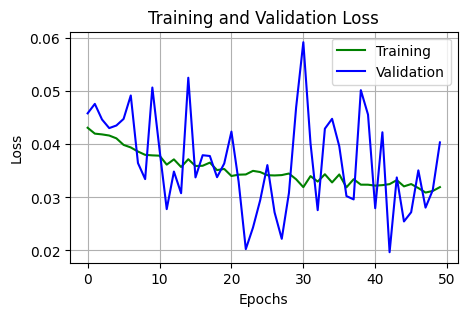

Final Training Loss:   0.031454
Final Validation Loss: 0.012719


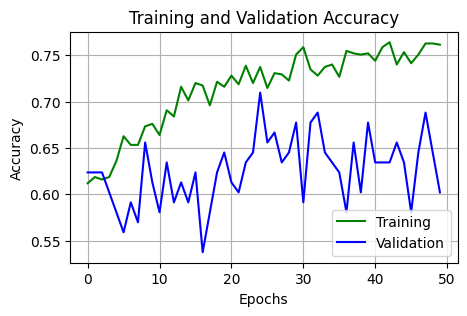

Final Training Accuracy:   0.770667
Final Validation Accuracy: 0.580645

Test Accuracy: 0.5625



In [16]:
num_correct_test = 0
evalModel = model
evalModel.load_state_dict(torch.load(WEIGHTS_PATH))
evalModel.eval()

test_loss = 0
test_correct = 0

for idx, batch in enumerate(iter(test_iter)):
  predictions = model(batch.sentence.to(device))
  labels = F.one_hot(batch.label, num_classes=2).float().to(device)
  test_loss = criterion(predictions, labels)

  correct = (torch.argmax(predictions, dim=1) == torch.argmax(labels, dim=1))

  test_correct += correct.sum()
  test_loss += loss.item()

  val_losses[epoch]   = test_loss/N_val
  val_accuracy[epoch] = test_correct/N_val

test_accuracy = test_correct / N_test

show_performance_curves(training_losses,val_losses,training_accuracy,val_accuracy,test_accuracy,last_epoch)